### as part of this connection, we have to determine if the regulatory overlay affects what water source type per water right site
 - i.e., groundwater regulatory overlay versus surface water overlay
 - will have to read in site.csv and watersource.csv from wr data -> determine watersource type per site -> determine watersource type per regulatory overlay area -> assign reUUID to wr site per matching watersource type

In [1]:
# this is apart of assigning reUUIDs to a wr site.
# do I need to read in watersource.csv?  RegulatoryOverlay info already has a WaterSourceTypeCV field.

In [2]:
# old approach
# # plot out polygon
# contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
# ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
# gplt.polyplot(gdf_iscr, ax=ax)

In [3]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# visulizaiton
import missingno as msno # creates a matrix chart to show missing values
import plotly.express as px
import plotly.graph_objects as go # for subplot creation
from plotly.subplots import make_subplots # for subplot creation
import matplotlib.pyplot as mplt # use with gplt to save fig to pdf

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [4]:
# Working Directory
workingDir = "G:/Shared drives/WaDE Data/NewMexico/Regulatory"
os.chdir(workingDir)

## Input Data

#### wade WR site.csv data
- convert to geodataframe

In [5]:
# NMwr sites.csv
dfs = pd.read_csv('G:/Shared drives/WaDE Data/NewMexico/WaterAllocation/ProcessedInputData/sites.csv')
print(len(dfs))
dfs.head(1)

260147


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SA00001,NaN,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,NaN,NaN,NaN,NaN,32.088525,-108.880519,NaN,NaN,POD,WaDE Unspecified,A-00001,NaN,WaDE Unspecified,NM,NaN


<GeoAxesSubplot: >

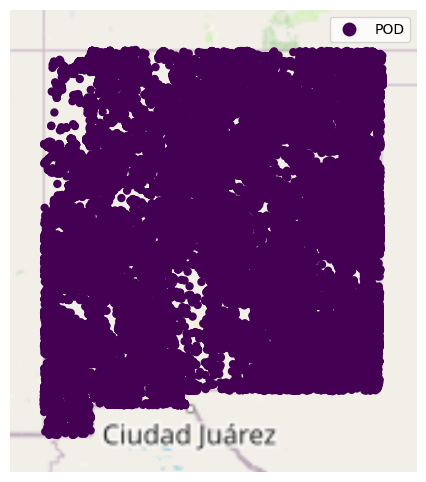

In [6]:
# Map out points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.Longitude.astype(float), dfs.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

#### wade regulatoryreportingunits.csv data

In [7]:
inputFile = "ProcessedInputData/regulatoryreportingunits.csv"
df_rru = pd.read_csv(inputFile)
print(len(df_rru))
df_rru.head(1)

206


,DataPublicationDate,OrganizationUUID,RegulatoryOverlayUUID,ReportingUnitUUID
0,05/02/2023,NMwr_O1,NMre_ROISCR0,NMre_RUISCR0


#### wade reportingunits.csv data

In [8]:
inputFile = "ProcessedInputData/reportingunits.csv"
dfru = pd.read_csv(inputFile)
print(len(dfru))
dfru.head(1)

209


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,WaDEUUID
0,NMre_RUISCR0,4326,McGaffey and Main Ground Water Management Area,ISCR0,NaN,Interstate River Compact,NaN,NM,POLYGON ((-105.50932300135537 36.9959380014376...,nmiscr0


# Extract RegulatoryOverlay from Reporting Units and assing to WR Sites

#### Interstate Stream Compact Regions

In [9]:
dfru_iscr = dfru.copy()
dfru_iscr = dfru_iscr[dfru_iscr['ReportingUnitTypeCV'] == 'Interstate River Compact']
dfru_iscr = pd.merge(dfru_iscr, df_rru[['ReportingUnitUUID', 'RegulatoryOverlayUUID']], left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')
print(len(dfru_iscr))
dfru_iscr.head(1)

8


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,WaDEUUID,RegulatoryOverlayUUID
0,NMre_RUISCR0,4326,McGaffey and Main Ground Water Management Area,ISCR0,NaN,Interstate River Compact,NaN,NM,POLYGON ((-105.50932300135537 36.9959380014376...,nmiscr0,NMre_ROISCR0


<GeoAxesSubplot: >

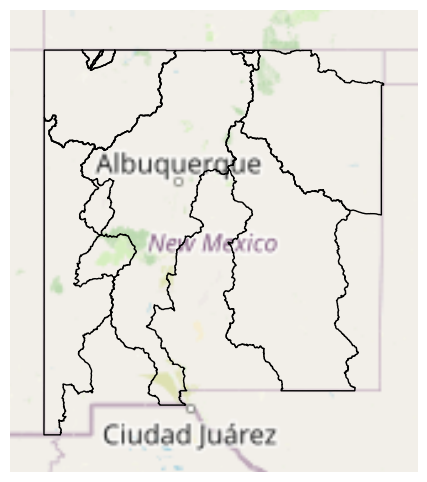

In [10]:
# Convert to geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_iscr = dfru_iscr[dfru_iscr['Geometry'] != ""].reset_index(drop=True)
dfru_iscr['Geometry'] = gpd.GeoSeries.from_wkt(dfru_iscr['Geometry'], crs="EPSG:4326")
gdfru_iscr = gpd.GeoDataFrame(dfru_iscr, geometry=dfru_iscr['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdf_iscr['Geometry'] = gdf_iscr.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_iscr, ax=ax)

In [11]:
# Select sites within polygon.
gdfs_iscr = gpd.sjoin(left_df=gdfs, right_df=gdfru_iscr[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_iscr))
gdfs_iscr.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


195797


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,NMwr_SA00001,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088525,-108.880519,,,POD,WaDE Unspecified,A-00001,,WaDE Unspecified,NM,,POINT (-108.88052 32.08853),7,NMre_RUISCR7,NMre_ROISCR7
1,NMwr_SA00001S,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088809,-108.880894,,,POD,WaDE Unspecified,A-00001-S,,WaDE Unspecified,NM,,POINT (-108.88089 32.08881),7,NMre_RUISCR7,NMre_ROISCR7
2,NMwr_SA00001S2,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088947,-108.880786,,,POD,WaDE Unspecified,A-00001-S2,,WaDE Unspecified,NM,,POINT (-108.88079 32.08895),7,NMre_RUISCR7,NMre_ROISCR7
3,NMwr_SA00002,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.239713,-108.845783,,,POD,WaDE Unspecified,A-00002,,WaDE Unspecified,NM,,POINT (-108.84578 32.23971),7,NMre_RUISCR7,NMre_ROISCR7
4,NMwr_SA00002S,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.235624,-108.845599,,,POD,WaDE Unspecified,A-00002-S,,WaDE Unspecified,NM,,POINT (-108.84560 32.23562),7,NMre_RUISCR7,NMre_ROISCR7


<GeoAxesSubplot: >

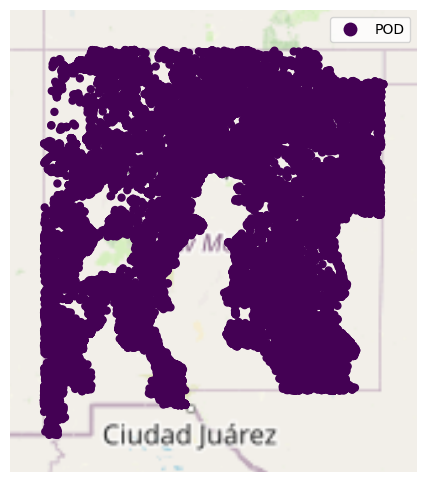

In [12]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(gdfs_iscr, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [13]:
# set RegulatoryOverlayUUIDs
gdfs_iscr['RegulatoryOverlayUUIDs'] = gdfs_iscr['RegulatoryOverlayUUID']
gdfs_iscr = gdfs_iscr.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID'], axis=1)
gdfs_iscr.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SA00001,NMre_ROISCR7,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088525,-108.880519,,,POD,WaDE Unspecified,A-00001,,WaDE Unspecified,NM,


#### OSE Water Right District Boundary

In [14]:
dfru_osewrb = dfru.copy()
dfru_osewrb = dfru_osewrb[dfru_osewrb['ReportingUnitTypeCV'] == 'Water Rights District']
dfru_osewrb = pd.merge(dfru_osewrb, df_rru[['ReportingUnitUUID', 'RegulatoryOverlayUUID']], left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')
print(len(dfru_osewrb))
dfru_osewrb.head(1)

7


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,WaDEUUID,RegulatoryOverlayUUID
0,NMre_RUOSEWRB1,4326,Estancia Poor Quality Area,OSEWRB1,NaN,Water Rights District,NaN,NM,POLYGON ((-106.94996204701084 36.2032551785836...,nmiscr6,NMre_ROOSEWR6


<GeoAxesSubplot: >

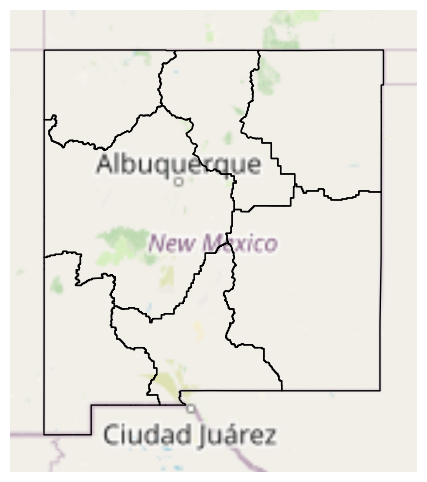

In [15]:
# Convert to geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_osewrb = dfru_osewrb[dfru_osewrb['Geometry'] != ""].reset_index(drop=True)
dfru_osewrb['Geometry'] = gpd.GeoSeries.from_wkt(dfru_osewrb['Geometry'], crs="EPSG:4326")
gdfru_osewrb = gpd.GeoDataFrame(dfru_osewrb, geometry=dfru_osewrb['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdfru_osewrb['Geometry'] = gdfru_osewrb.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_osewrb, ax=ax)

In [16]:
# Select sites within polygon.
gdfs_osewrb = gpd.sjoin(left_df=gdfs, right_df=gdfru_osewrb[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_osewrb))
gdfs_osewrb.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


260103


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,NMwr_SA00001,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088525,-108.880519,,,POD,WaDE Unspecified,A-00001,,WaDE Unspecified,NM,,POINT (-108.88052 32.08853),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
1,NMwr_SA00001S,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088809,-108.880894,,,POD,WaDE Unspecified,A-00001-S,,WaDE Unspecified,NM,,POINT (-108.88089 32.08881),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
2,NMwr_SA00001S2,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088947,-108.880786,,,POD,WaDE Unspecified,A-00001-S2,,WaDE Unspecified,NM,,POINT (-108.88079 32.08895),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
3,NMwr_SA00002,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.239713,-108.845783,,,POD,WaDE Unspecified,A-00002,,WaDE Unspecified,NM,,POINT (-108.84578 32.23971),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
4,NMwr_SA00002S,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.235624,-108.845599,,,POD,WaDE Unspecified,A-00002-S,,WaDE Unspecified,NM,,POINT (-108.84560 32.23562),2,NMre_RUOSEWRB3,NMre_ROOSEWR4


<GeoAxesSubplot: >

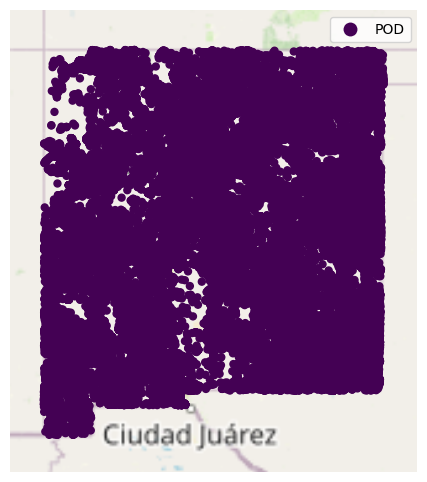

In [17]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(gdfs_osewrb, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [18]:
# set RegulatoryOverlayUUIDs
gdfs_osewrb['RegulatoryOverlayUUIDs'] = gdfs_osewrb['RegulatoryOverlayUUID']
gdfs_osewrb = gdfs_osewrb.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID'], axis=1)
gdfs_osewrb.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SA00001,NMre_ROOSEWR4,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088525,-108.880519,,,POD,WaDE Unspecified,A-00001,,WaDE Unspecified,NM,


#### Special Conditions Water Right

In [19]:
dfru_scwr = dfru.copy()
dfru_scwr = dfru_scwr[dfru_scwr['ReportingUnitTypeCV'] == 'Water Rights District']
dfru_scwr = pd.merge(dfru_scwr, df_rru[['ReportingUnitUUID', 'RegulatoryOverlayUUID']], left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')
print(len(dfru_scwr))
dfru_scwr.head(1)

7


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,WaDEUUID,RegulatoryOverlayUUID
0,NMre_RUOSEWRB1,4326,Estancia Poor Quality Area,OSEWRB1,NaN,Water Rights District,NaN,NM,POLYGON ((-106.94996204701084 36.2032551785836...,nmiscr6,NMre_ROOSEWR6


<GeoAxesSubplot: >

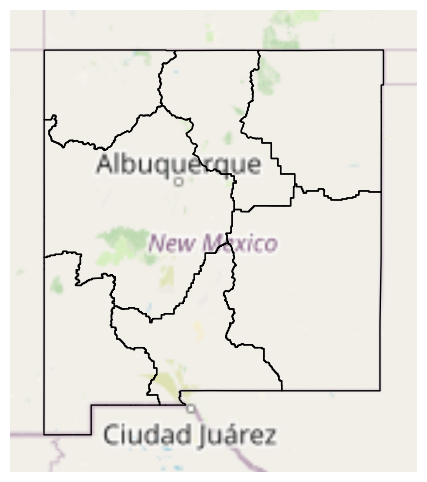

In [20]:
# Convert to geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_scwr = dfru_scwr[dfru_scwr['Geometry'] != ""].reset_index(drop=True)
dfru_scwr['Geometry'] = gpd.GeoSeries.from_wkt(dfru_scwr['Geometry'], crs="EPSG:4326")
gdfru_scwr = gpd.GeoDataFrame(dfru_scwr, geometry=dfru_scwr['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdfru_scwr['Geometry'] = gdfru_scwr.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_scwr, ax=ax)

In [21]:
# Select sites within polygon.
gdfs_scwr = gpd.sjoin(left_df=gdfs, right_df=gdfru_scwr[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_scwr))
gdfs_scwr.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


260103


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,NMwr_SA00001,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088525,-108.880519,,,POD,WaDE Unspecified,A-00001,,WaDE Unspecified,NM,,POINT (-108.88052 32.08853),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
1,NMwr_SA00001S,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088809,-108.880894,,,POD,WaDE Unspecified,A-00001-S,,WaDE Unspecified,NM,,POINT (-108.88089 32.08881),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
2,NMwr_SA00001S2,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088947,-108.880786,,,POD,WaDE Unspecified,A-00001-S2,,WaDE Unspecified,NM,,POINT (-108.88079 32.08895),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
3,NMwr_SA00002,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.239713,-108.845783,,,POD,WaDE Unspecified,A-00002,,WaDE Unspecified,NM,,POINT (-108.84578 32.23971),2,NMre_RUOSEWRB3,NMre_ROOSEWR4
4,NMwr_SA00002S,,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.235624,-108.845599,,,POD,WaDE Unspecified,A-00002-S,,WaDE Unspecified,NM,,POINT (-108.84560 32.23562),2,NMre_RUOSEWRB3,NMre_ROOSEWR4


In [22]:
# plot the selected points
# contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
# ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(gdfs_scwr, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

<GeoAxesSubplot: >

In [23]:
# set RegulatoryOverlayUUIDs
gdfs_scwr['RegulatoryOverlayUUIDs'] = gdfs_scwr['RegulatoryOverlayUUID']
gdfs_scwr = gdfs_scwr.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID'], axis=1)
gdfs_scwr.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SA00001,NMre_ROOSEWR4,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.088525,-108.880519,,,POD,WaDE Unspecified,A-00001,,WaDE Unspecified,NM,


# Merge Dataframes
- drop geometry from the wade wr sites.csv geodataframe

In [24]:
# Concatenate dataframes
gdfs = gdfs.drop(['geometry'], axis=1)

frames = [gdfs, gdfs_iscr, gdfs_osewrb, gdfs_scwr] # add dataframes here
outdf = pd.concat(frames)
outdf = outdf.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
print(len(outdf))

716047


In [25]:
# groupby() fields on SiteNativeID
outdf = outdf.groupby('SiteNativeID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem!=''])).replace(np.nan, "").reset_index()
print(len(outdf))

260147


# Inspect Output Data & Export

In [26]:
outdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260147 entries, 0 to 260146
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteNativeID            260147 non-null  object
 1   SiteUUID                260147 non-null  object
 2   RegulatoryOverlayUUIDs  260147 non-null  object
 3   WaterSourceUUIDs        260147 non-null  object
 4   CoordinateAccuracy      260147 non-null  object
 5   CoordinateMethodCV      260147 non-null  object
 6   County                  260147 non-null  object
 7   EPSGCodeCV              260147 non-null  object
 8   Geometry                260147 non-null  object
 9   GNISCodeCV              260147 non-null  object
 10  HUC12                   260147 non-null  object
 11  HUC8                    260147 non-null  object
 12  Latitude                260147 non-null  object
 13  Longitude               260147 non-null  object
 14  NHDNetworkStatusCV      260147 non-n

In [27]:
outdf

,SiteNativeID,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,A-00001,NMwr_SA00001,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.08852543145729,-108.88051896223872,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
1,A-00001-S,NMwr_SA00001S,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.08880863623688,-108.88089406970218,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
2,A-00001-S2,NMwr_SA00001S2,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.08894715341991,-108.8807855981426,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
3,A-00002,NMwr_SA00002,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.23971296437374,-108.8457832111845,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
4,A-00002-S,NMwr_SA00002S,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.23562412371736,-108.84559903738057,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260142,VV-00197-POD1,NMwr_SVV00197POD1,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.67544752484973,-108.99534708909248,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
260143,VV-00198-POD1,NMwr_SVV00198POD1,"NMre_ROOSEWR4,NMre_ROISCR7",NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.69541658839018,-109.02172178459696,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
260144,VV-00199-POD1,NMwr_SVV00199POD1,"NMre_ROOSEWR4,NMre_ROISCR7",,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.68716662119876,-108.99855516895518,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,
260145,VV-00200-POD1,NMwr_SVV00200POD1,"NMre_ROOSEWR4,NMre_ROISCR7",,WaDE Unspecified,WaDE Unspecified,Hidalgo,4326,,,,,32.694497030308995,-109.03772483144748,,,POD,WaDE Unspecified,,WaDE Unspecified,NM,


In [28]:
#outdf.to_csv('ProcessedInputData/sites.csv', index=False)
outdf.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder